Context: let's learn by tackling a complex Kaggle challenge and improving my code by inspiring (read: stealing with pride - and reference) from the best in class.

references used to benchmark & improve this notebook:

https://www.kaggle.com/gpreda/santander-eda-and-prediction

https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

learnings:
- good to compare distributions between response variable types
- good to compare distributions between train and test if you have generalization problems
- a few nice functions to recycle
- beware of synthethic data in samples ("if at least one of the sample's features is unique, then the sample must be a real sample")
- LightGBM use case

In [1]:
import pandas as pd
import numpy as np
import os
import numpy as np
import seaborn as sns
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold



%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format
sns.set_style("whitegrid")

In [2]:
datasets = r'input'
output = r'output'

# Overview

The goal here is to predict which of the customers in the sample data are likely to perform a transaction. 

Let's start with some EDA to look at our data. We're trying to understand a few things:

- What does our data look like (train, test, type of features)
- What can we understand about our features (spoiler: in this case, little)
- How are those features related to the response variable
- How close is the training set to the test set (a big difference might compromise predictive power)

In [3]:
%%time

#let's look at the data

snt_train = pd.read_csv(os.path.join(datasets,r'train.csv'), dtype={0:'str'})
snt_test = pd.read_csv(os.path.join(datasets,r'test.csv'), dtype={0:'str'}) 

Wall time: 13.4 s


In [4]:
#let's look at basic info - what does the data look like and shape
#we can already understand that, given we lack a data dictionary, we won't understand much from feature names
snt_train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,train_199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [5]:
snt_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [6]:
snt_test.shape

(200000, 201)

In [7]:
#we now know we have 200k observations, with 200 variables, excluding the ID columns (which we can use as index)

snt_train.set_index('ID_code', inplace=True)
snt_test.set_index('ID_code', inplace=True)

In [8]:
#let's assess if we're missing data

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
%%time
mischeck = missing_data(snt_train)
mischeck

Wall time: 472 ms


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Types,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
#no missing values
mischeck.iloc[0].sum()

0

In [11]:
#only numerical variables
mischeck.iloc[2].unique()

array(['int64', 'float64'], dtype=object)

In [12]:
#let's look at what our target variable looks like
#it's a binary variable
#~10% of records have a "1" - we should bear in mind the risk of the rare class problem due to an unbalanced dataset

print(snt_train['target'].value_counts())
print(snt_train[snt_train['target'] == 1].shape[0] / snt_train.shape[0])

0    179902
1     20098
Name: target, dtype: int64
0.10049


<AxesSubplot:xlabel='target', ylabel='count'>

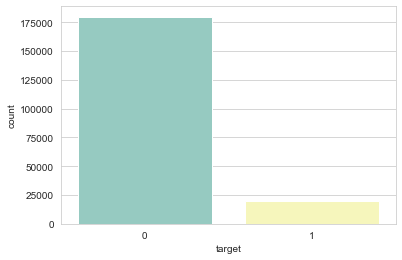

In [13]:
sns.countplot(x=snt_train['target'], palette='Set3')

In [14]:
%%time
#let's get a feel of what our variables look like

descs = snt_train.describe()
descs

Wall time: 2.62 s


,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,"200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000",...,"200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000","200,000.0000"
mean,0.1005,10.6799,-1.6276,10.7152,6.7965,11.0783,-5.0653,5.4089,16.5458,0.2842,...,3.2344,7.4384,1.9278,3.3318,17.9938,-0.1421,2.3033,8.9082,15.8707,-3.3265
std,0.3007,3.0401,4.0500,2.6409,2.0433,1.6231,7.8633,0.8666,3.4181,3.3326,...,4.5599,3.0233,1.4784,3.9920,3.1352,1.4294,5.4544,0.9216,3.0109,10.4380
min,0.0000,0.4084,-15.0434,2.1171,-0.0402,5.0748,-32.5626,2.3473,5.3497,-10.5055,...,-14.0933,-2.6917,-3.8145,-11.7834,8.6944,-5.2610,-14.2096,5.9606,6.2993,-38.8528
25%,0.0000,8.4539,-4.7400,8.7225,5.2541,9.8832,-11.2004,4.7677,13.9438,-2.3178,...,-0.0588,5.1574,0.8898,0.5846,15.6298,-1.1707,-1.9469,8.2528,13.8297,-11.2085
50%,0.0000,10.5248,-1.6080,10.5800,6.8250,11.1082,-4.8331,5.3851,16.4568,0.3937,...,3.2036,7.3477,1.9013,3.3963,17.9579,-0.1727,2.4089,8.8882,15.9340,-2.8196
75%,0.0000,12.7582,1.3586,12.5167,8.3241,12.2611,0.9248,6.0030,19.1029,2.9379,...,6.4062,9.5125,2.9495,6.2058,20.3965,0.8296,6.5567,9.5933,18.0647,4.8368
max,1.0000,20.3150,10.3768,19.3530,13.1883,16.6714,17.2516,8.4477,27.6918,10.1513,...,18.4409,16.7165,8.4024,18.2818,27.9288,4.2729,18.3215,12.0004,26.0791,28.5007


In [15]:
#the variables differ quite a bit in terms of mean
print(descs.iloc[1].max())
print(descs.iloc[1].min())

24.52107786050052
-16.548147023999846


In [16]:
#...and std
print(descs.iloc[2].max())
print(descs.iloc[2].min())

21.404911544677045
0.007186267883143501


In [17]:
#the scale also looks different, with some having negative values
print(descs.iloc[7].max())
print(descs.iloc[3].min())

74.0321
-90.2525


<Figure size 432x288 with 0 Axes>

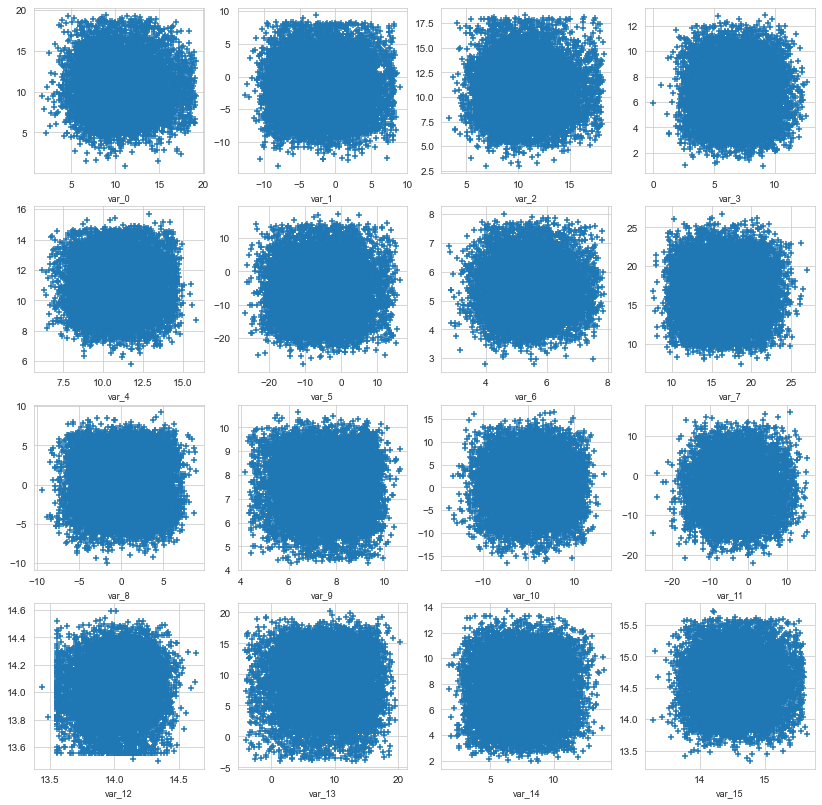

In [18]:
#let's steal a nice plotting function from our references to make a pretty selection of graphs
#we'll compare test (y) and train (x) data to see how similar their are

def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show()

features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(snt_train[::20],snt_test[::20], features)

In [19]:
#let's steal with pride another plotting function, this time to look at feature density plots, distinguishing by target value
#with some adaptions since the library changed a bit over the last few years 

def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
#        sns.distplot(df1[feature], hist=False,label=label1) deprecated
#        sns.distplot(df2[feature], hist=False,label=label2) deprecated
        sns.kdeplot(data=df1[feature], label=label1)
        sns.kdeplot(data=df2[feature], label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

<Figure size 432x288 with 0 Axes>

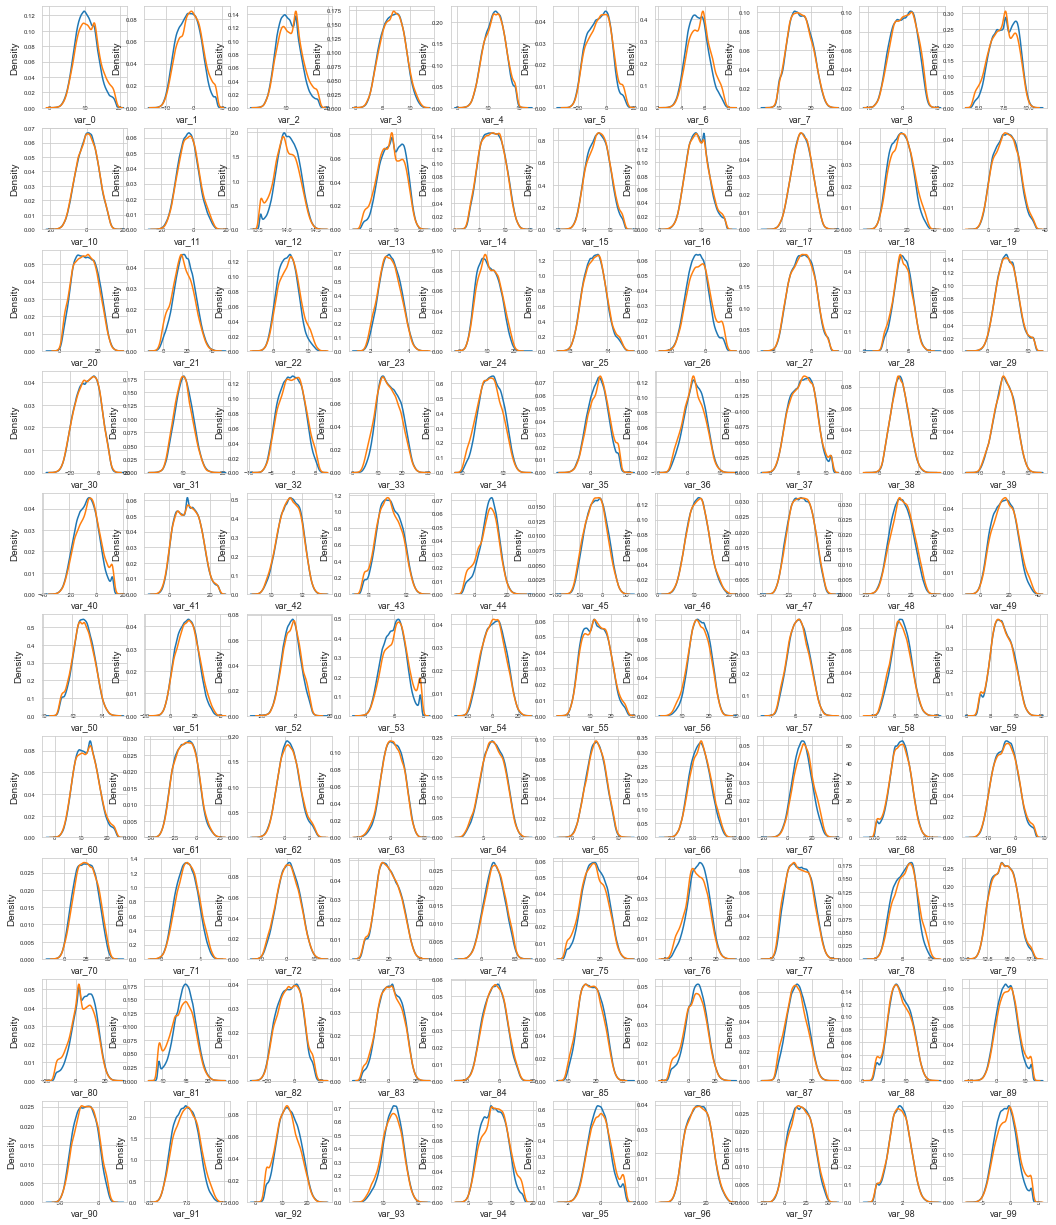

Wall time: 2min 25s


In [20]:
%%time

t0 = snt_train.loc[snt_train['target'] == 0]
t1 = snt_train.loc[snt_train['target'] == 1]
features = snt_train.columns.values[1:101]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

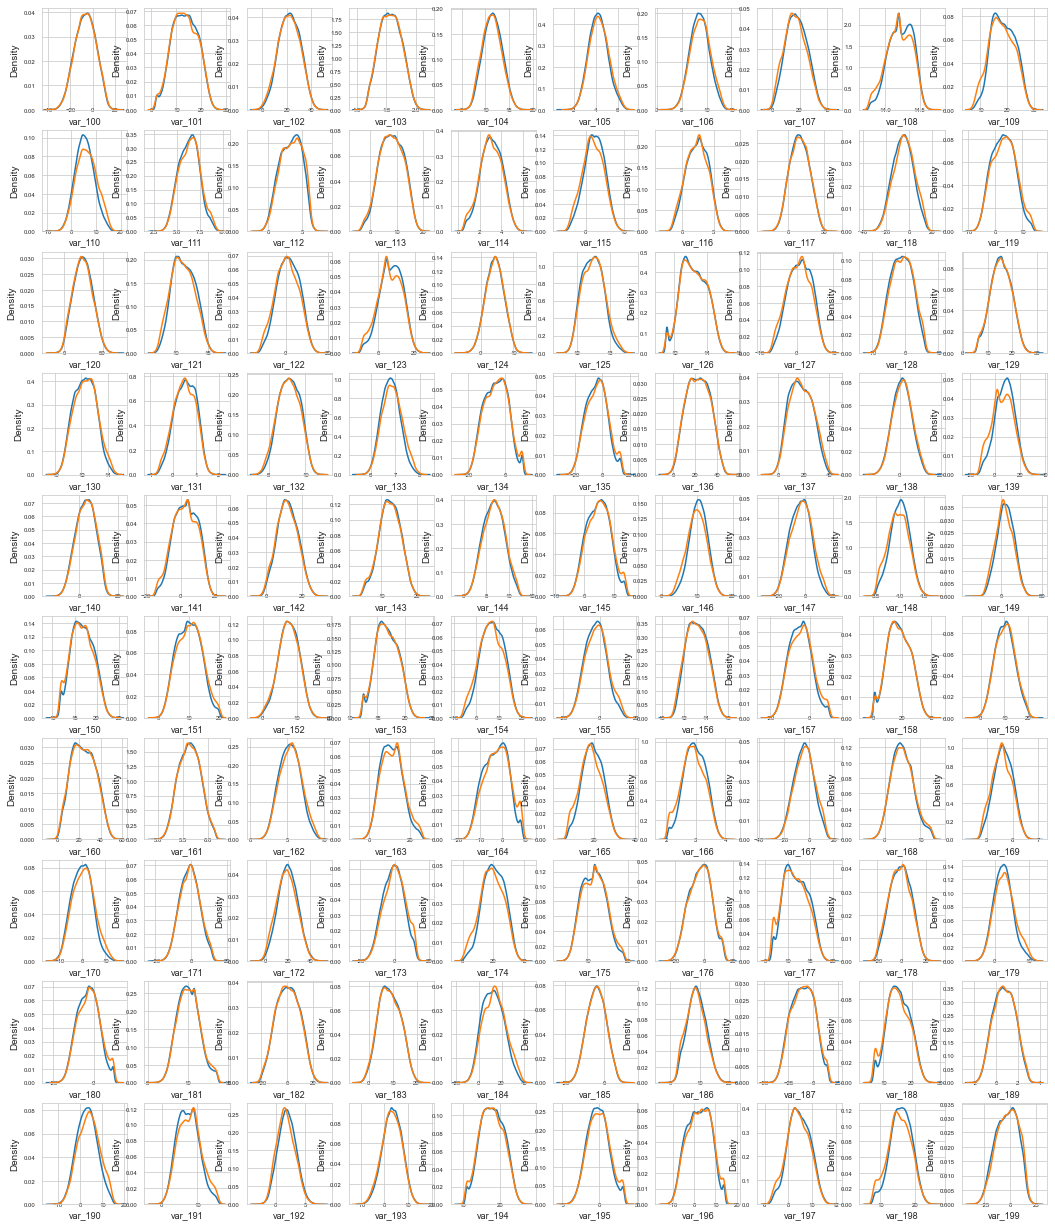

Wall time: 2min 19s


In [21]:
%%time

t0 = snt_train.loc[snt_train['target'] == 0]
t1 = snt_train.loc[snt_train['target'] == 1]
features = snt_train.columns.values[101:201]
plot_feature_distribution(t0, t1, '0', '1', features)

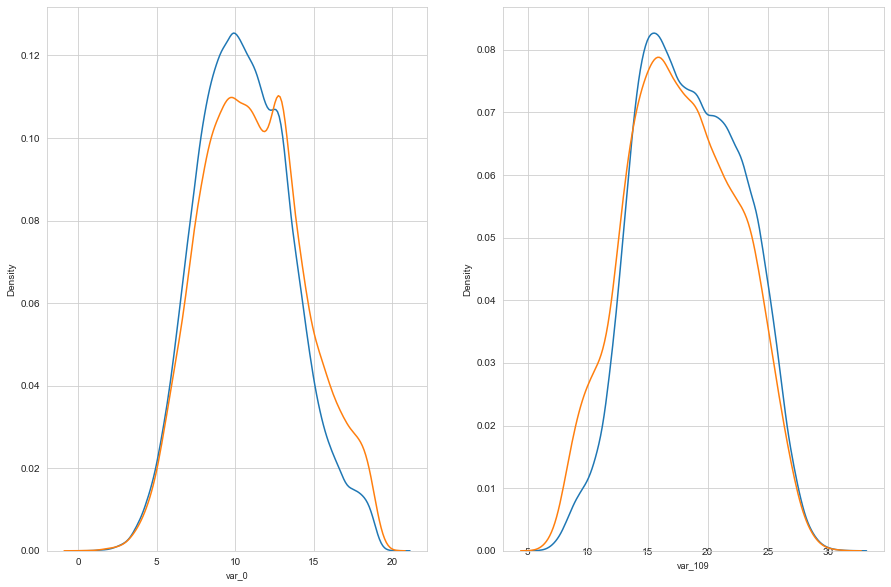

In [22]:
#a number of the features are different when comparing responses
#for example, let's look at a couple

fig, ax = plt.subplots(1,2,figsize=(15,10))
#plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
sns.kdeplot(data=snt_train.loc[snt_train['target'] == 0]['var_0'], label='0')
sns.kdeplot(data=snt_train.loc[snt_train['target'] == 1]['var_0'], label='1')
plt.xlabel('var_0', fontsize=9)

plt.subplot(1,2,2)
sns.kdeplot(data=snt_train.loc[snt_train['target'] == 0]['var_109'], label='0')
sns.kdeplot(data=snt_train.loc[snt_train['target'] == 1]['var_109'], label='1')
plt.xlabel('var_109', fontsize=9)

locs, labels = plt.xticks()
plt.tick_params(axis='x', which='major', pad=-6)
plt.tick_params(axis='y', which='major')
plt.show()

<Figure size 432x288 with 0 Axes>

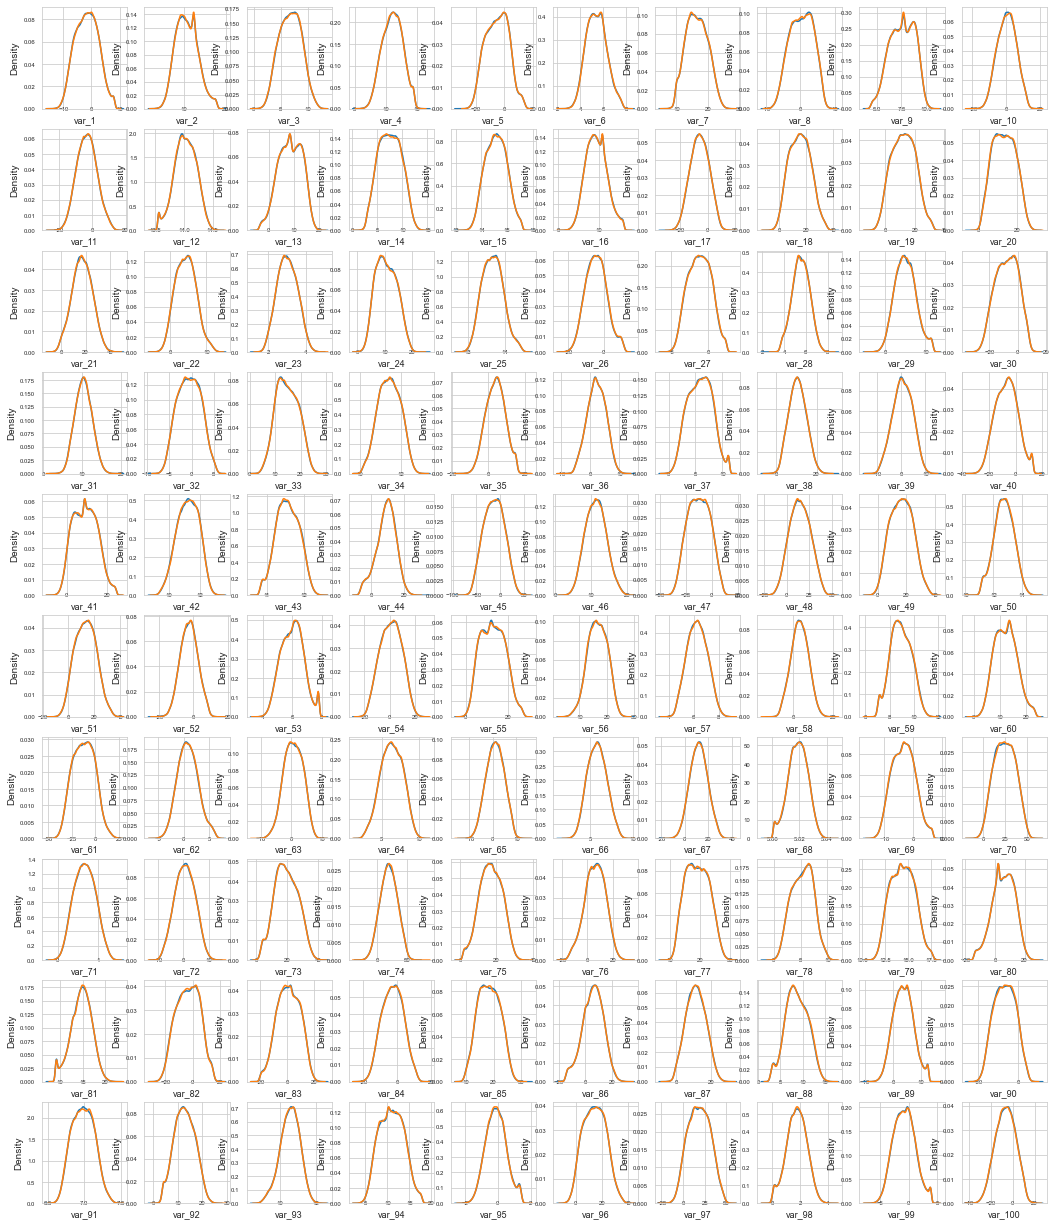

In [23]:
#let's compare train vs test df in terms of distributions - they look quite alike

features = snt_train.columns.values[2:102]
plot_feature_distribution(snt_train, snt_test, 'train', 'test', features)

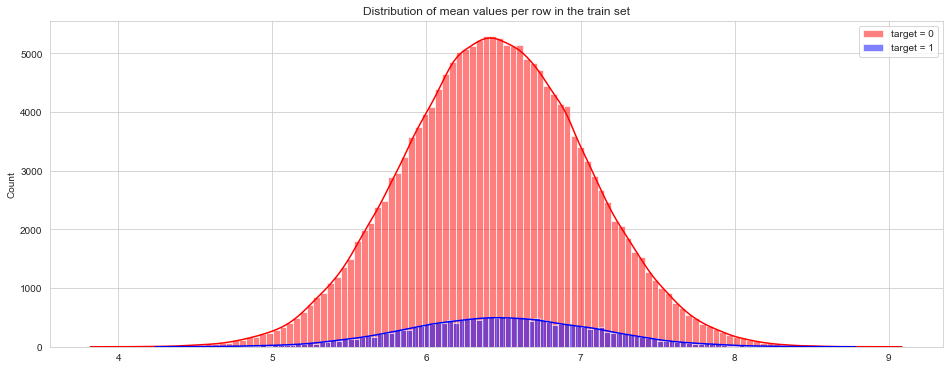

In [24]:
#let's also look at the means per row in the training data, comparing positive vs negative classes

t0 = snt_train.loc[snt_train['target'] == 0]
t1 = snt_train.loc[snt_train['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.histplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.histplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend()
plt.show()

In [25]:
%%time

#duplicates check, per column
#let's see most fequent/duplicate values

features = snt_train.columns.values[2:202]
unique_max_train = []
unique_max_test = []

for feature in features:
    values = snt_train[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = snt_test[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

Wall time: 8.41 s


In [26]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))


,67,107,125,11,90,102,147,70,160,24,124,132,42,165,168
Feature,var_68,var_108,var_126,var_12,var_91,var_103,var_148,var_71,var_161,var_25,var_125,var_133,var_43,var_166,var_169
Max duplicates,1084,313,305,203,66,61,59,54,52,41,40,39,39,39,39
Value,5.0214,14.1999,11.5356,13.5545,6.9785,1.6662,4.0456,0.7031,5.7688,13.6723,12.5159,6.8632,11.5531,2.7306,5.6941


In [27]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))


,67,125,107,11,90,102,147,160,24,70,42,165,124,168,132
Feature,var_68,var_126,var_108,var_12,var_91,var_103,var_148,var_161,var_25,var_71,var_43,var_166,var_125,var_169,var_133
Max duplicates,1104,307,302,188,86,78,74,69,60,60,58,53,53,51,50
Value,5.0197,11.5357,14.1999,13.5546,6.9939,1.4659,4.0004,5.7114,13.5965,0.5389,11.5738,2.8446,12.2189,5.8455,6.6873


The test set is partially composed of synthethic observations. Let's try identifying the synthetic samples
Assumption: if at least one feature for an observation is unique, then the observation must be real

In [28]:
from tqdm.notebook import tqdm

unique_samples = []
unique_count = np.zeros_like(snt_test)
for feature in tqdm(range(snt_test.shape[1])):
    _, index_, count_ = np.unique(snt_test.iloc[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1
    
#Samples which have unique values are real the others are fake
real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

print(len(real_samples_indexes))
print(len(synthetic_samples_indexes))

  0%|          | 0/200 [00:00<?, ?it/s]

100000
100000


In [29]:
#half the test data is fake!

In [30]:
%%time

#create correlation matrix, sort it, and exclude correlations among same variable
#smart way to get a correlation df
correlations = snt_train[features].corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

#top correlations
correlations.head(10)

Wall time: 24.9 s


,level_0,level_1,0
199,var_139,var_26,0.0098
200,var_26,var_139,0.0098
201,var_53,var_148,0.0098
202,var_148,var_53,0.0098
203,var_81,var_165,0.0097
204,var_165,var_81,0.0097
205,var_174,var_81,0.0095
206,var_81,var_174,0.0095
207,var_189,var_183,0.0094
208,var_183,var_189,0.0094


In [31]:
#bottom correlations
correlations.tail(10)

,level_0,level_1,0
39591,var_177,var_100,0.0000
39592,var_100,var_177,0.0000
39593,var_144,var_27,0.0000
39594,var_27,var_144,0.0000
39595,var_126,var_109,0.0000
39596,var_109,var_126,0.0000
39597,var_173,var_6,0.0000
39598,var_6,var_173,0.0000
39599,var_191,var_75,0.0000
39600,var_75,var_191,0.0000


# Feature engineering 

We now went through our dataset. Let's test a baseline model to see where we'd be if we started with modeling now


In [32]:
snt_train

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995


In [33]:
%%time

#for this first test, we don't want yet to touch test data
#for maximum rigor, we'll just cross validate over the training set
#we'll also scale the training set, else logistic regression will struggle a bit
#class weight = balanced is a quite important step when the response variable is unevenly distributed, like in this case

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


X_train, X_test, y_train, y_test = train_test_split(snt_train.drop(columns=['target']), snt_train['target'], test_size=0.3, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)




print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87    126046
           1       0.28      0.77      0.41     13954

    accuracy                           0.78    140000
   macro avg       0.63      0.78      0.64    140000
weighted avg       0.90      0.78      0.82    140000

0.7774205428904991
Wall time: 6.21 s


Our baseline model has, in cross-validation, a ROC AUC score of 78%, which is not bad at all for the first basic, with minimal feature engineering and tuning
The precision-recall tradeoff will have to be explored (ideally, with some domain export input, to decide which one we care most about), but for a first result, it's fairly decent

Let's see how can we improve our results

For starters, we can create aggregated values for existing features

In [34]:
%%time
idx = features = snt_train.columns.values[2:201]

for df in [snt_test, snt_train]:
    df['sum'] = df[idx].sum(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

Wall time: 13.7 s


In [35]:
#let's see what we built
snt_train[snt_train.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,med
ID_code,,,,,,,,
train_0,"1,447.3927",-21.4494,43.1127,7.2733,9.3543,0.1040,1.3112,6.7602
train_1,"1,403.8630",-47.3797,40.5632,7.0546,10.3574,-0.3452,4.0851,7.1051
train_2,"1,232.2873",-22.4038,33.8820,6.1924,8.7738,-0.0528,0.5311,5.8463
train_3,"1,277.1715",-35.1659,38.1015,6.4179,9.6126,-0.4730,2.6109,6.5850
train_4,"1,344.3941",-65.4863,41.1037,6.7557,11.3135,-1.4566,9.7260,6.9087


In [36]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4,figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], label=label1)
        sns.kdeplot(df2[feature], label=label2)
        plt.xlabel(feature, fontsize=11)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)
    plt.show()
    


<Figure size 432x288 with 0 Axes>

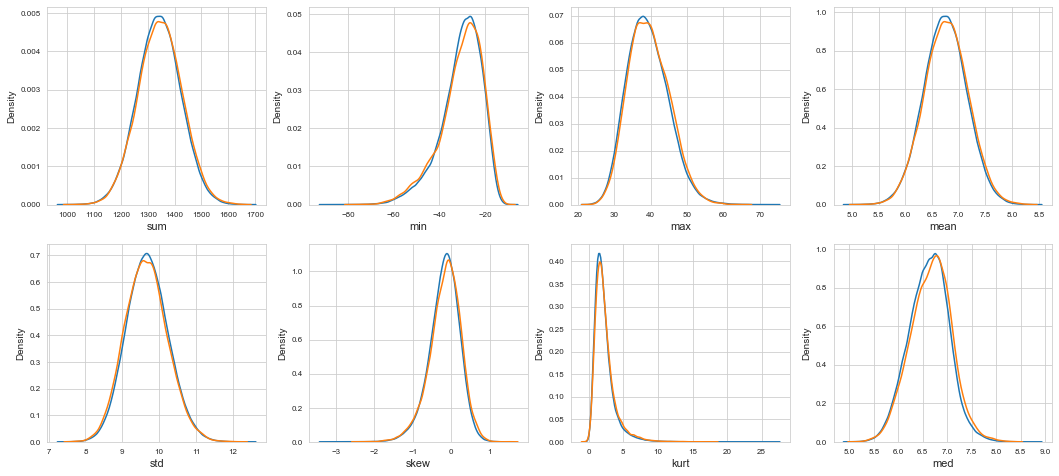

Wall time: 14.3 s


In [37]:
%%time
#let's compare the distribution of the new variables based on the the response variable


t0 = snt_train.loc[snt_train['target'] == 0]
t1 = snt_train.loc[snt_train['target'] == 1]
features = snt_train.columns.values[201:]
plot_new_feature_distribution(t0, t1, 'target: 0', 'target: 1', features)

<Figure size 432x288 with 0 Axes>

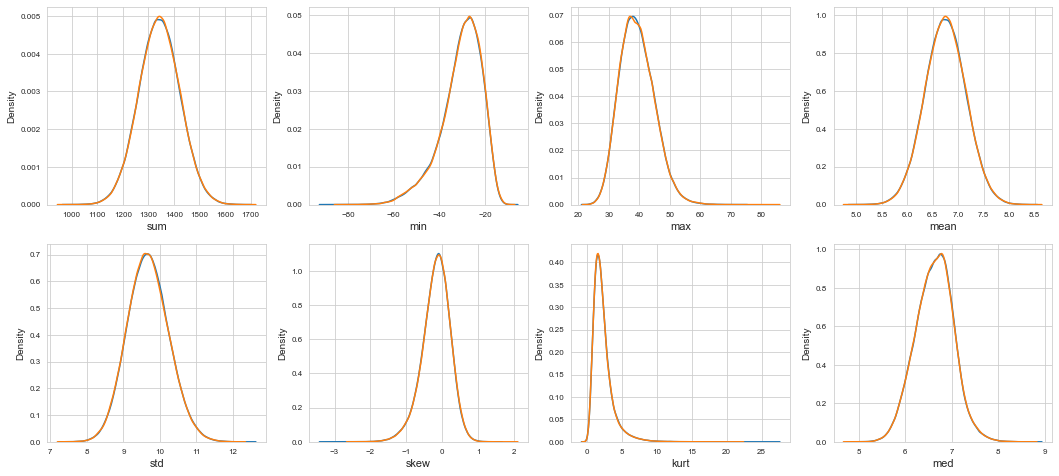

In [38]:
#and across train and test 

features = snt_train.columns.values[201:]
plot_new_feature_distribution(snt_train, snt_test, 'train', 'test', features)

# Modeling

Since we don't know too much about our features, it's hard to do smarter manipulations or to apply domain knowledge / common sense.

Let's go to modeling. This is an iterative process, in any event, so we can always go back to feature engineering to try out new approaches.

In [39]:
#let's re-try our previous logistic classifier
#there a slight (~1 percentage point) increase in the ROC AUC

X_train, X_test, y_train, y_test = train_test_split(snt_train.drop(columns=['target']), snt_train['target'], test_size=0.3, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)

clf = LogisticRegression(random_state=42, class_weight='balanced')
clf.fit(X_train, y_train) 
y_pred = cross_val_predict(clf, X_train, y_train, cv=5)

print(classification_report(y_train, y_pred))
print(sklearn.metrics.roc_auc_score(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.79      0.87    126046
           1       0.29      0.78      0.42     13954

    accuracy                           0.79    140000
   macro avg       0.63      0.78      0.65    140000
weighted avg       0.90      0.79      0.83    140000

0.7842310247575961


let's see what we can achieve with a better model - let's try LightGBM and XGBoost

In [40]:
#let's set the parameters

param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [41]:
features = [c for c in snt_train.columns if c not in ['target']]
target = snt_train['target']

In [42]:
%%time

folds = StratifiedKFold(n_splits=3, shuffle=False)
oof = np.zeros(len(snt_train)) #out of fold validation
predictions = np.zeros(len(snt_test))
predictions_train = np.zeros(len(snt_train))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(snt_train.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(snt_train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(snt_train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], callbacks=[lgb.early_stopping(3000), lgb.log_evaluation(1000)])
    oof[val_idx] = clf.predict(snt_train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    #predict using avg value of predictions per each fold
    predictions += clf.predict(snt_test[features], num_iteration=clf.best_iteration) / folds.n_splits
    predictions_train += clf.predict(snt_train[features], num_iteration=clf.best_iteration) / folds.n_splits


print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))


Fold 0
[LightGBM] [Info] Number of positive: 13399, number of negative: 119934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 53040
[LightGBM] [Info] Number of data points in the train set: 133333, number of used features: 208
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.893413	valid_1's auc: 0.869566
[2000]	training's auc: 0.911017	valid_1's auc: 0.882349
[3000]	training's auc: 0.922747	valid_1's auc: 0.889124
[4000]	training's auc: 0.93067	valid_1's auc: 0.892488
[5000]	training's auc: 0.937045	valid_1's auc: 0.89449
[6000]	training's auc: 0.942583	valid_1's auc: 0.89555
[7000]	training's auc: 0.947423	valid_1's auc: 0.896417
[8000]	training's auc: 0.951896	valid_1's auc: 0.896875
[9000]	training's auc: 0.955987	valid_1's auc: 0.897065
[10000]	training's auc: 0.959882	valid_1's auc: 0.897227
[1100

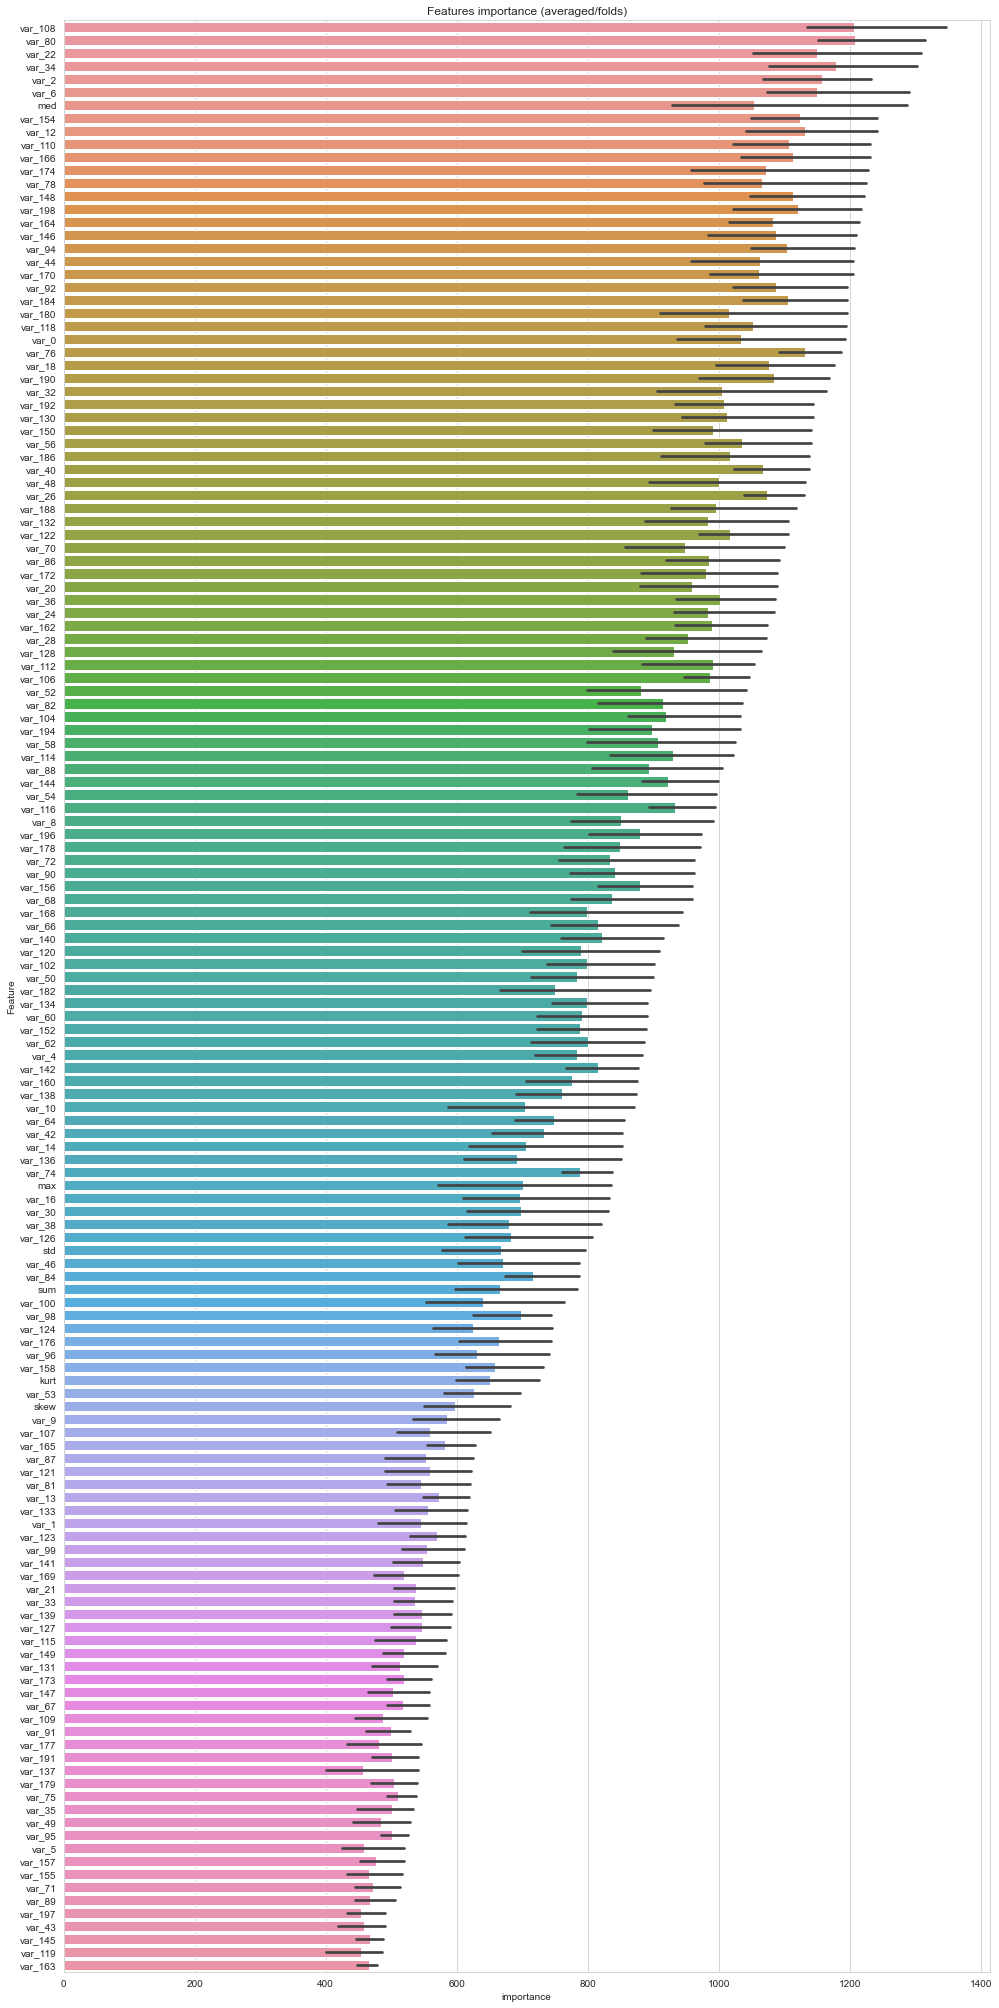

In [43]:
#let's take a look at the feature importances

cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [44]:
snt_train

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_198,var_199,sum,min,max,mean,std,skew,kurt,med
ID_code,,,,,,,,,,,,,,,,,,,,,
train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,12.7803,-1.0914,"1,447.3927",-21.4494,43.1127,7.2733,9.3543,0.1040,1.3112,6.7602
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,18.3560,1.9518,"1,403.8630",-47.3797,40.5632,7.0546,10.3574,-0.3452,4.0851,7.1051
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,14.7222,0.3965,"1,232.2873",-22.4038,33.8820,6.1924,8.7738,-0.0528,0.5311,5.8463
train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,17.9697,-8.9996,"1,277.1715",-35.1659,38.1015,6.4179,9.6126,-0.4730,2.6109,6.5850
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,17.9974,-8.8104,"1,344.3941",-65.4863,41.1037,6.7557,11.3135,-1.4566,9.7260,6.9087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,...,16.6660,-17.8661,"1,337.5945",-23.6064,35.4923,6.7216,9.5868,-0.0414,0.8053,6.3582
train_199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,...,15.9054,0.3388,"1,345.7848",-39.6406,38.8105,6.7627,10.3333,-0.5552,2.5965,6.5953
train_199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,...,13.8329,4.1995,"1,363.7152",-49.5007,43.0307,6.8528,9.8412,-0.7438,5.8043,6.4020


In [45]:
predictions

array([0.07835196, 0.1975432 , 0.1645866 , ..., 0.00401014, 0.10688103,
       0.05055894])

In [46]:
#validation in full training data
#note that ROC score is very different when scoring with a threshold than when using probabilities
#https://stackoverflow.com/questions/56397128/roc-auc-score-is-different-while-calculating-using-predict-vs-predict-proba

preds = []
tresh = 0.5

for i in predictions_train:
    if i > tresh:
        preds.append(1)
    else:
        preds.append(0)

print(classification_report(snt_train['target'], preds))
print(sklearn.metrics.roc_auc_score(snt_train['target'], preds))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97    179902
           1       0.89      0.45      0.60     20098

    accuracy                           0.94    200000
   macro avg       0.92      0.72      0.78    200000
weighted avg       0.94      0.94      0.93    200000

0.7209284925096363


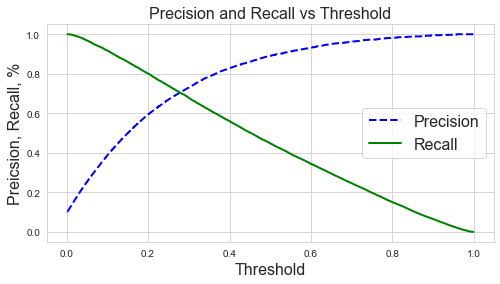

In [47]:
#let's take a look at the precision & recall trade thresholds

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(snt_train['target'], predictions_train)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="best", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.ylabel("Preicsion, Recall, %", fontsize=16)
    plt.grid(True)                              
    plt.title('Precision and Recall vs Threshold', fontsize=16)
    

plt.figure(figsize=(8, 4))                     
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

Let's test an XGBoost and see what it gives

In [48]:
%%time

import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(snt_train.drop(columns=['target']), snt_train['target'], test_size=0.3, random_state=42)

xgb_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.01,
    n_estimators=100,
    verbosity=1,
    silent=None,
    objective='binary:logistic',
    booster='gbtree',
    n_jobs=4,
    nthread=None,
    gamma=5,
    min_child_weight=1,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel=1,
    colsample_bynode=1,
    reg_alpha=0,
    reg_lambda=0,
    scale_pos_weight=1,
    base_score=0.5,
    random_state=0,
    seed=42,
    use_label_encoder=False,
    eval_metric  = 'logloss',
    missing = np.NaN
)

xgb_dmat = xgb.DMatrix(X_train, label=y_train)

#sc = StandardScaler()
#sc.fit(X_train)
#X_train = sc.transform(X_train)
#X_test = sc.transform(X_test)

xgb_model.fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test, y_test)))

from sklearn.metrics import classification_report,confusion_matrix
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(sklearn.metrics.roc_auc_score(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.90
              precision    recall  f1-score   support

           0       0.90      1.00      0.95     53856
           1       0.86      0.00      0.00      6144

    accuracy                           0.90     60000
   macro avg       0.88      0.50      0.47     60000
weighted avg       0.89      0.90      0.85     60000

0.5004789972333631
Wall time: 4min 2s


In [49]:
%%time

#add weight to XGB and see if it improves results

outcome = 'target'

default_wt = 1 / np.mean(y_train)
wt = [default_wt if outcome == 1 else 1 for outcome in y_train]
sum(wt)/len(wt)

from sklearn.metrics import classification_report,confusion_matrix
#scale_pos_weight = total_negative_examples / total_positive_examples
y_train_0 = len(y_train) - sum(y_train)
wt_xgb = y_train_0/sum(y_train)

xgb_model.fit(X_train, y_train, sample_weight=wt)
print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(sklearn.metrics.roc_auc_score(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.69
Accuracy of XGB classifier on test set: 0.68
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     53856
           1       0.20      0.69      0.30      6144

    accuracy                           0.68     60000
   macro avg       0.57      0.68      0.55     60000
weighted avg       0.87      0.68      0.74     60000

0.6826969720179737
Wall time: 4min 29s


Marked improvement. Still not as good as LightGBM.
Now would be a good moment to run a grid search.